### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

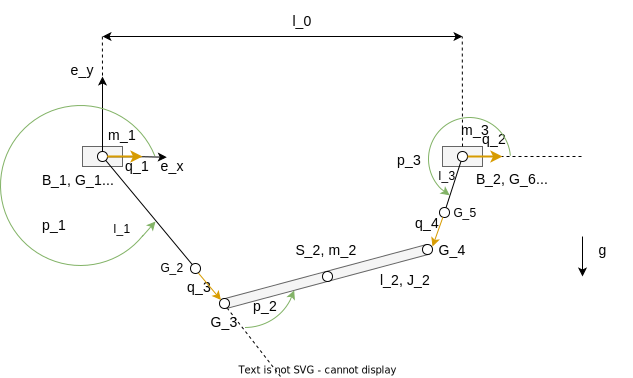

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='DAE_double_crane_fully_actuated.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates
nq = 4 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates

# vector of control inputs
aa = st.symb_vector("a1:{0}".format(nq+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

st.make_global(ttheta, tthetad, tthetadd)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂  q₃  q₄]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂  q̇₃  q̇₄]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂  q̈₃  q̈₄]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# joints 2 and 3 (load joints)
G2 = G1 + Rz(p1)*ex*l1 ##:
G3 = G2 + Rz(p1)*ex*q3 ##:

# center of mass of load
G5 = G6 + Rz(p3)*ex*l3 ##:
G4 = G5 + Rz(p3)*ex*q4 ##:
S2 = G3 + (G4-G3)*s2/l2 ##:

# alternative route to G4 for constraints
G4b = G3 + Rz(p1+p2)*ex*l2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G2 := ⎡l₁⋅cos(p₁) + q₁⎤
⎢               ⎥
⎣  l₁⋅sin(p₁)   ⎦

---

G3 := ⎡l₁⋅cos(p₁) + q₁ + q₃⋅cos(p₁)⎤
⎢                            ⎥
⎣  l₁⋅sin(p₁) + q₃⋅sin(p₁)   ⎦

---

G5 := ⎡l₀ + l₃⋅cos(p₃) + q₂⎤
⎢                    ⎥
⎣     l₃⋅sin(p₃)     ⎦

---

G4 := ⎡l₀ + l₃⋅cos(p₃) + q₂ + q₄⋅cos(p₃)⎤
⎢                                 ⎥
⎣     l₃⋅sin(p₃) + q₄⋅sin(p₃)     ⎦

---

S2 := ⎡                               s₂⋅(l₀ - l₁⋅cos(p₁) + l₃⋅cos(p₃) - q₁ + q₂ - q
⎢l₁⋅cos(p₁) + q₁ + q₃⋅cos(p₁) + ──────────────────────────────────────────────
⎢                                                                 l₂          
⎢                                                                             
⎢                                   s₂⋅(-l₁⋅sin(p₁) + l₃⋅sin(p₃) - q₃⋅sin(p₁) 
⎢         l₁⋅sin(p₁) + q₃⋅sin(p₁) + ──────────────────────────────────────────
⎣                                                              l₂             

₃⋅cos(p₁) + q₄⋅cos(p₃))⎤
───────────────────────⎥
                       ⎥
                       ⎥
+ q₄⋅sin(p₃))          ⎥
─────────────          ⎥
                       ⎦

---

G4b := ⎡l₁⋅cos(p₁) + l₂⋅cos(p₁ + p₂) + q₁ + q₃⋅cos(p₁)⎤
⎢                                              ⎥
⎣  l₁⋅sin(p₁) + l₂⋅sin(p₁ + p₂) + q₃⋅sin(p₁)   ⎦

---

(Sd1, Sd2, Sd3) := ⎛      ⎡                                                   s₂⋅(l₁⋅ṗ₁⋅sin(p₁) 
⎜      ⎢-l₁⋅ṗ₁⋅sin(p₁) - ṗ₁⋅q₃⋅sin(p₁) + q̇₁ + q̇₃⋅cos(p₁) + ───────────────
⎜⎡q̇₁⎤  ⎢                                                                     
⎜⎢  ⎥, ⎢                                                                      
⎜⎣0 ⎦  ⎢                                                    s₂⋅(-l₁⋅ṗ₁⋅cos(p₁
⎜      ⎢       l₁⋅ṗ₁⋅cos(p₁) + ṗ₁⋅q₃⋅cos(p₁) + q̇₃⋅sin(p₁) + ───────────────
⎝      ⎣                                                                      

- l₃⋅ṗ₃⋅sin(p₃) + ṗ₁⋅q₃⋅sin(p₁) - ṗ₃⋅q₄⋅sin(p₃) - q̇₁ + q̇₂ - q̇₃⋅cos(p₁) +
──────────────────────────────────────────────────────────────────────────────
                                l₂                                            
                                                                              
) + l₃⋅ṗ₃⋅cos(p₃) - ṗ₁⋅q₃⋅cos(p₁) + ṗ₃⋅q₄⋅cos(p₃) - q̇₃⋅sin(p₁) + q̇₄⋅sin(p
────────────────────────────────

---

In [6]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * (pdot1+pdot2)**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# TODO: correct treatment for V ???
# max length of rope
q3max = 0.3
# potential energy, for l1 <= l2
V = m2*g*(l1+q3max + s2 + S2[1]) ##:

---

---

In [7]:
import pickle

# load model from pickle file instead of calculating it which takes a lot of time
loading_model = 1

if loading_model == 1:
    with open("DAE_fully_actuated_crane.pcl", "rb") as pfile:
        mod = pickle.load(pfile)

else:
    # dissipation included here! -d1*qdot1, -d4*qdot2 should be in control input function later
    external_forces = [0 , 0, 0, tau1, tau2, tau3, tau4]
    
    # model generation with Lagragian Mechanics
    mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[G4 - G4b])
    
    # write the model to disk to save time in the next run of the notebook
    with open("DAE_fully_actuated_crane.pcl", "wb") as pfile:
        pickle.dump(mod, pfile)

In [8]:
# implicit(=0) system equations 
mod.eqns

⎡                                        2                                    
⎢g⋅l₂⋅m₂⋅(l₁ + q₃)⋅(l₂ - s₂)⋅cos(p₁) + l₂ ⋅(J₂⋅(p̈₁ + p̈₂) - λ₁⋅(l₁⋅sin(p₁) + 
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢          ⎛                       2                                   ⎛      
⎢(l₃ + q₄)⋅⎝g⋅l₂⋅m₂⋅s₂⋅cos(p₃) + l₂ ⋅(λ₁⋅sin(p₃) - λ₂⋅cos(p₃)) + m₂⋅s₂⋅⎝l₁⋅l₂⋅
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                   

In [9]:
mod.tau

⎡τ₁⎤
⎢  ⎥
⎢τ₂⎥
⎢  ⎥
⎢τ₃⎥
⎢  ⎥
⎣τ₄⎦

In [10]:
mod.eqns.jacobian(mod.tau)

⎡0   0   0   0 ⎤
⎢              ⎥
⎢0   0   0   0 ⎥
⎢              ⎥
⎢0   0   0   0 ⎥
⎢              ⎥
⎢-1  0   0   0 ⎥
⎢              ⎥
⎢0   -1  0   0 ⎥
⎢              ⎥
⎢0   0   -1  0 ⎥
⎢              ⎥
⎣0   0   0   -1⎦

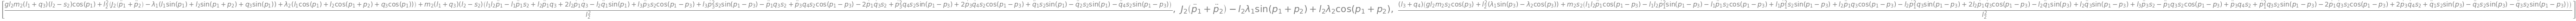

In [11]:
mod.eqns[0:3]

### Creation of DAE System

In [12]:
parameter_values = list(dict(s2=0.15, m1=0.45, m2=0.557, m3=0.45, J2=0.000221, mc1b=39, mc2b=36.3, d1=9.76, d4=11.2, l0=0.5, l1=0.4, l2=0.3, l3=0.4, g=9.81).items()) ##:
# tbd: J2, d1, d4

parameter_values := [('s2', 0.15),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('J2', 0.000221),
 ('mc1b', 39),
 ('mc2b', 36.3),
 ('d1', 9.76),
 ('d4', 11.2),
 ('l0', 0.5),
 ('l1', 0.4),
 ('l2', 0.3),
 ('l3', 0.4),
 ('g', 9.81)]

---

#### Visualization of kinematics for debugging and placement of initial values

In [13]:
# matrix of joints
joints = sp.Matrix.hstack(G1, G2, G3, G4, G5, G6) ##:
joints = joints.subs(parameter_values)
# constraints equations (implicit) as vector
constraints = mod.constraints ##:
constraints = constraints.subs(parameter_values)

# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta, joints, modules="numpy")

# cost function of constraints, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def constraint_cost(theta_var, theta_const):
    err = constraints_func(theta_const[0], *theta_var, theta_const[1], theta_const[2], theta_const[3], theta_const[4])
    return err[0]**2 +err[1]**2 # squared error

joints := ⎡q₁  l₁⋅cos(p₁) + q₁  l₁⋅cos(p₁) + q₁ + q₃⋅cos(p₁)  l₀ + l₃⋅cos(p₃) + q₂ + q₄⋅
⎢                                                                             
⎣0     l₁⋅sin(p₁)       l₁⋅sin(p₁) + q₃⋅sin(p₁)          l₃⋅sin(p₃) + q₄⋅sin(p

cos(p₃)  l₀ + l₃⋅cos(p₃) + q₂  l₀ + q₂⎤
                                      ⎥
₃)            l₃⋅sin(p₃)          0   ⎦

---

constraints := ⎡l₀ - l₁⋅cos(p₁) - l₂⋅cos(p₁ + p₂) + l₃⋅cos(p₃) - q₁ + q₂ - q₃⋅cos(p₁) + q₄⋅co
⎢                                                                             
⎣       -l₁⋅sin(p₁) - l₂⋅sin(p₁ + p₂) + l₃⋅sin(p₃) - q₃⋅sin(p₁) + q₄⋅sin(p₃)  

s(p₃)⎤
     ⎥
     ⎦

---

Initial Values:
p1: 5.1
p2: 1.059819394358637
p2: -1.5973816338597095
q1: 0.0
q2: 0.0
q3: 0.1
q3: 0.1
error of constraints: 
 [[ 1.93371588e-08]
 [-5.55577390e-09]] 



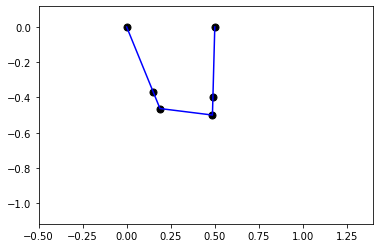

In [14]:
%matplotlib inline

init_theta = []

from ipywidgets import interact
@interact(p1=(4.6, 5.6, .1), q1=(-1, 1, .1), q2=(-1, 1, .1), q3=(0, 0.3, .1), q4=(0, 0.3, .1))
def plot_func(p1, q1, q2, q3, q4):
    res = fmin(constraint_cost, x0=[0, 0], args=([p1, q1, q2, q3, q4],), disp=0, ftol=1e-15)

    # dependent coordinates
    p2, p3 = res
    jc = joint_coords = joints_func(p1, p2, p3, q1, q2, q3, q4)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    init_theta[:] = [p1, p2, p3, q1, q2, q3, q4]
    const_err = constraints_func(*init_theta)
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p2: {p3}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'q3: {q3}\n'
                   f'q3: {q4}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

#### DAE system for simulation

In [15]:
# generate numerical DAE system from implicit system equations
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [16]:
# degrees of freedom of DAE system
dae.ndof

In [17]:
# DAE's states and its derivatives
dae.yy ##:T
dae.yyd ##:T

(dae.yy).T := [p₁  p₂  p₃  q₁  q₂  q₃  q₄  ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂  q̇₃  q̇₄  λ₁  λ₂]

---

(dae.yyd).T := [ẏ₁  ẏ₂  ẏ₃  ẏ₄  ẏ₅  ẏ₆  ẏ₇  ẏ₈  ẏ₉  ẏ₁₀  ẏ₁₁  ẏ₁₂  ẏ₁₃  ẏ₁₄  ẏ₁₅  ẏ₁₆]

---

In [18]:
# implicit equations of the DAE system
dae.eqns

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [19]:
# control input vector of DAE system
dae.mod.tau

⎡τ₁⎤
⎢  ⎥
⎢τ₂⎥
⎢  ⎥
⎢τ₃⎥
⎢  ⎥
⎣τ₄⎦

In [20]:
# define closed loop (usage of yy) control function for input
# di*yy[] terms represent dissipation in carts
def new_input_func(yy, t):
    u1 = mc1b.subs(parameter_values)*yy[1] - d1.subs(parameter_values) * yy[8]
    u2 = mc2b.subs(parameter_values)*yy[1] - d4.subs(parameter_values) * yy[9]
    u3 = 0
    u4 = 0
    return [u1, u2, u3, u4]

# set as input of DAE system
dae.input_func = new_input_func ##:

(dae.input_func) := <function __main__.new_input_func(yy, t)>

---

In [21]:
### check error of constraints for initial values
dae.constraints_func(*init_theta) ##:

# calculate consistent initial values from latest visualization
yy0, yyd0 = dae.calc_consistent_init_vals(p1=init_theta[0], q1=init_theta[3], q2=init_theta[4], q3=init_theta[5], q4=init_theta[6], _ftol=1e-9) ##:

t0 = 0

# evaluation of implicit DAE System (should be almost 0 if initial values fulfill the model)
dae.model_func(t0, yy0, yyd0) ##:

# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

TypeError: 'MutableDenseMatrix' object is not callable

In [ ]:
# defining assimulo problem
model = Overdetermined_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'gantry crane'

# indicate which components of y are differential (1) and which are purely algebraic (0)
model.algvar = dae.diff_alg_vars ##:

# definition of simulation of DAE system with ODASSL solver
sim = SOLVER(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

In [ ]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# simulation of DAE system
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

In [ ]:
# trajectories of coordinates and its velocities
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("theta")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("dot theta")

####  Visualization and Animation of simulation solution

In [ ]:
joint_pos_expr = st.col_stack(G1, G2, G3, G4).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())





*Preliminary Conclusion*

→ Behavior looks more or less realistic - up to the configurations where $p_1$ is an integer multiple of $\pi$ (joint is fully streched or fully bended). Probably there are singularities.

#### Save animation

In [ ]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
writer = animation.FFMpegWriter(fps=30)
ani.save("gantry_crane.webm", writer=writer)

In [ ]:
%%HTML
<video width="320" height="240" controls>
  <source src="gantry_crane.webm" type="video/webm">
</video>